Predict number of rented bikes using ARIMA and ARIMAX

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import residuals_plot
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA 
import pmdarima as pm
from skforecast.model_selection_statsmodels import grid_search_sarimax

df1=pd.read_csv('day.csv', parse_dates=['dteday'])
df1

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Drop some unnecessary data

In [2]:
df1=df1.drop(['instant','casual'], axis=1)

Plot histograms

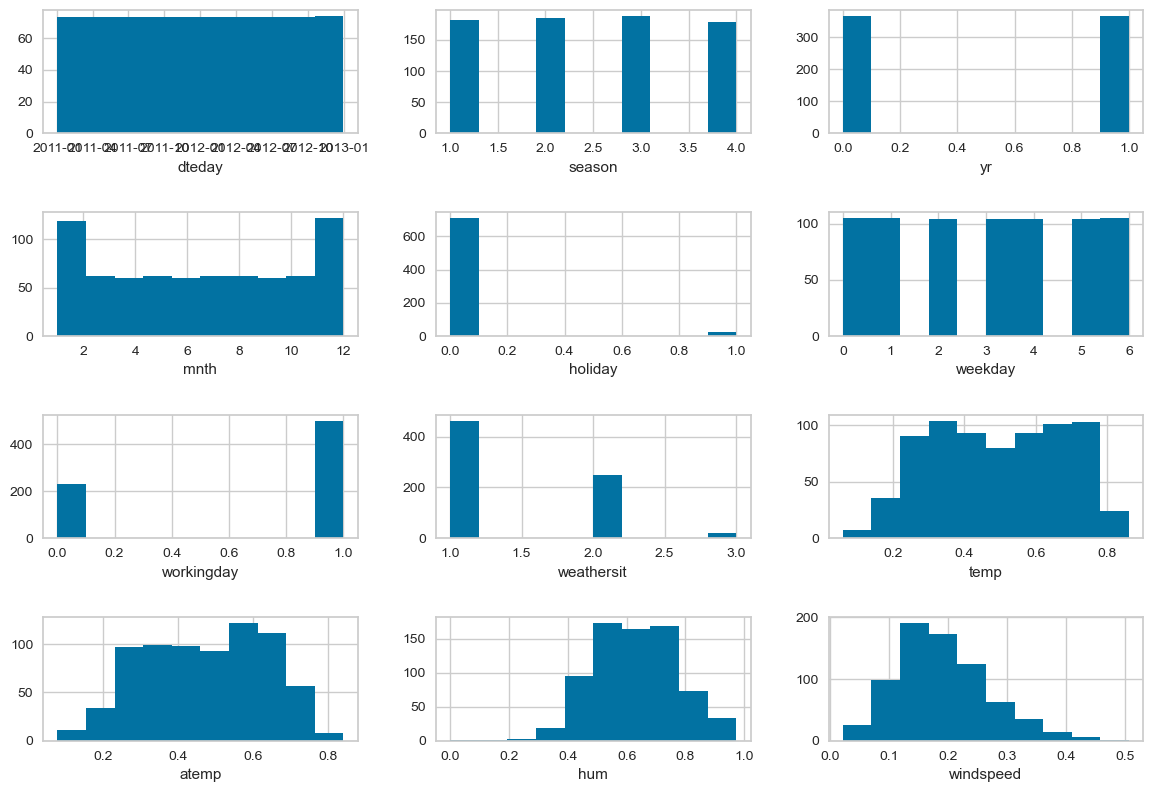

In [3]:
fig=plt.figure(figsize=(12,10))
count=0
for i in range(4):
    for j in range(3):
        plt.subplot2grid((5,3),(i,j))
        plt.hist(df1[df1.columns[count]])
        plt.xlabel(df1.columns[count])
        plt.tight_layout(pad=2)
        count+=1


Plot box

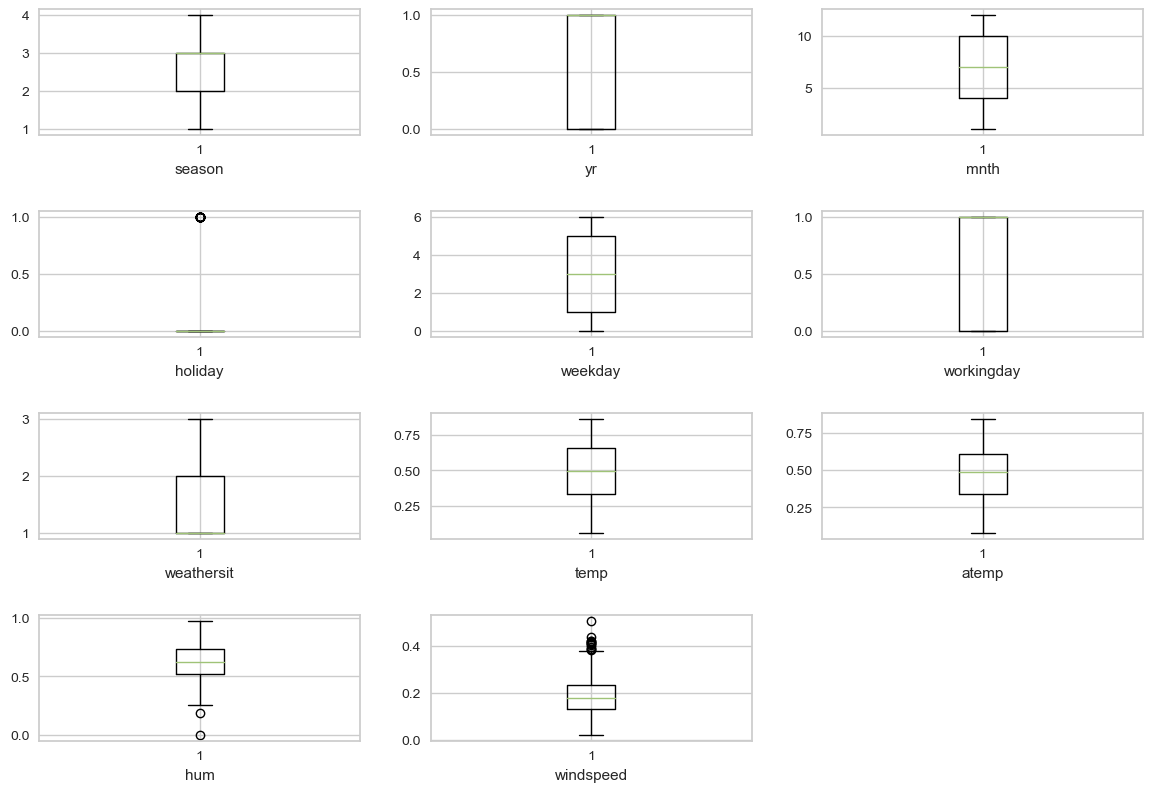

In [4]:
fig=plt.figure(figsize=(12,10))
count=1
for i in range(4):
    for j in range(3):
        if count== 12:
            break
        plt.subplot2grid((5,3),(i,j))
        plt.boxplot(df1[df1.columns[count]])
        plt.xlabel(df1.columns[count])
        plt.tight_layout(pad=2)
        count+=1

Check if there is any duplicated data

In [5]:
df1.duplicated().sum()

0

Check if there is any nun value

In [6]:
df1.isna().sum()

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
registered    0
cnt           0
dtype: int64

In [7]:
df1['dteday'].describe()

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_34605/916621911.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df1['dteday'].describe()


count                     731
unique                    731
top       2011-01-01 00:00:00
freq                        1
first     2011-01-01 00:00:00
last      2012-12-31 00:00:00
Name: dteday, dtype: object

I select the train to be from the first of 2011 till first of May 2012 and the rest of months of 2021 serves as test dataset

In [8]:
df1=df1.set_index('dteday')

In [9]:
df1

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,registered,cnt
dteday,,,,,,,,,,,,,
2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,654,985
2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,670,801
2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,1229,1349
2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,1454,1562
2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,1867,2114
2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,2451,3095
2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,1182,1341


Plot the time series to see any trend or seasonality

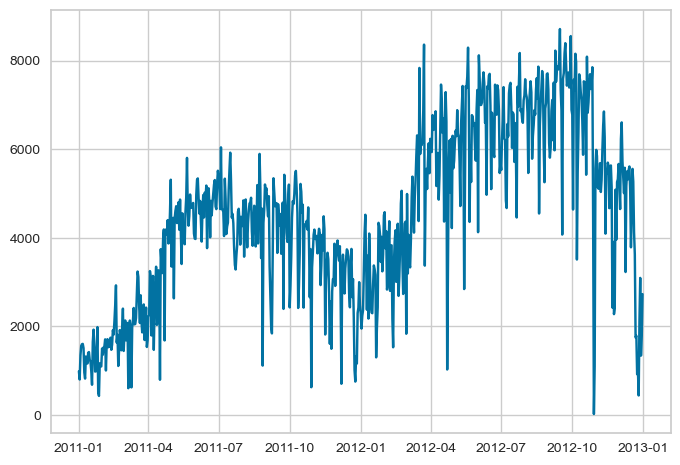

In [10]:
plt.plot(df1['cnt'])

There is a yearly and weekly seasonality. 

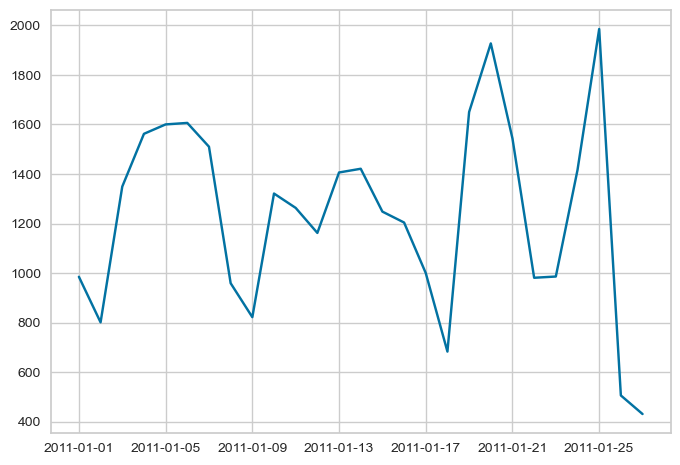

In [11]:
c=df1[df1.index < '2011-01-28']
plt.plot(c['cnt'])

Plot ACF and PACF

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


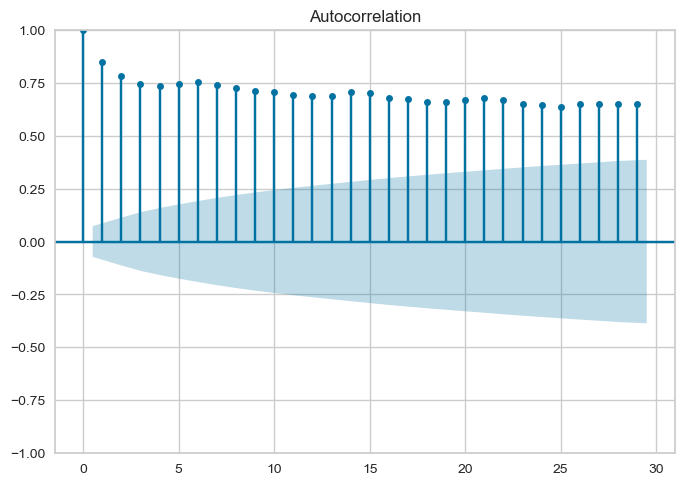

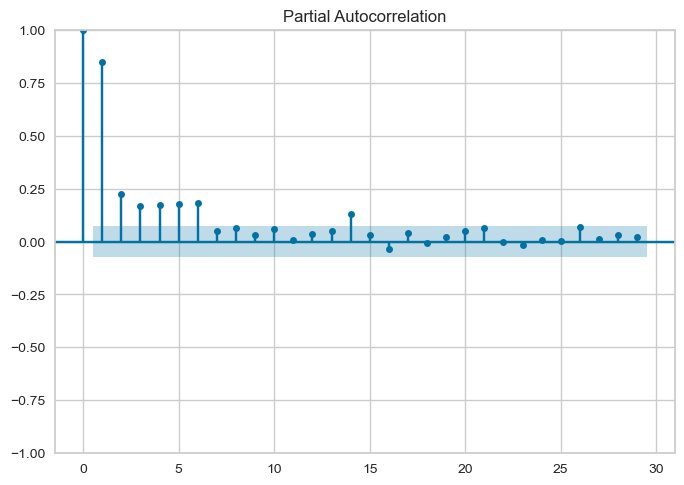

In [12]:
acf_df1=plot_acf(df1['cnt'])
pacf_df1=plot_pacf(df1['cnt'])

Make the stationary test using ADF

In [13]:
result=adfuller(df1.cnt)
print('P-value: ',result[1])

P-value:  0.3427434403392201


Since p is larger than significant value (0.05), null hypothesis is valid (time series is non-stationary). Let's make the time series stationary and then look at the ACF and PACF again

In [14]:
df1_a=df1.diff().dropna()

check the stazionarity of time series

In [15]:
result=adfuller(df1_a.cnt)
print('P-value: ',result[1])


P-value:  1.0467797548019514e-21


So p value is smaller than significant value (0.05), therefore time series is stationary. So with one differencing , time series becomes stationary (d=1). Plot ACF and PACF again for the stationary time series.

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


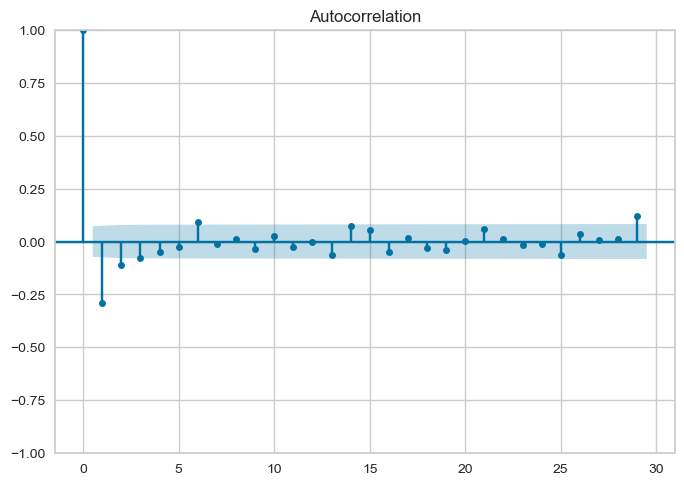

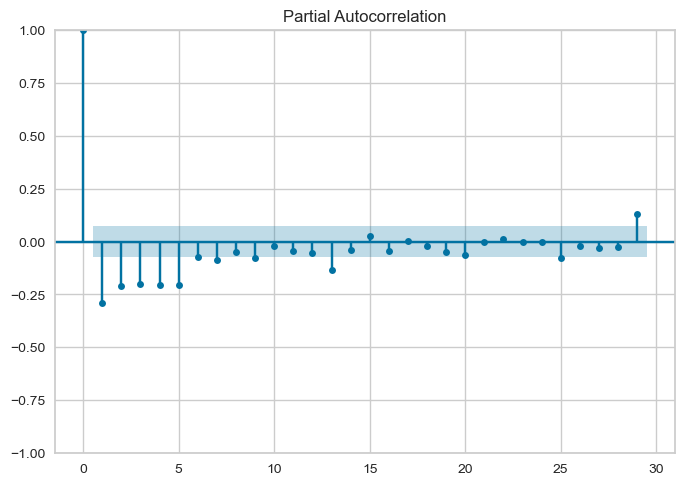

In [16]:
acf_df1_a=plot_acf(df1_a['cnt'])
pacf_df1_a=plot_pacf(df1_a['cnt'])

First split the data to train and test

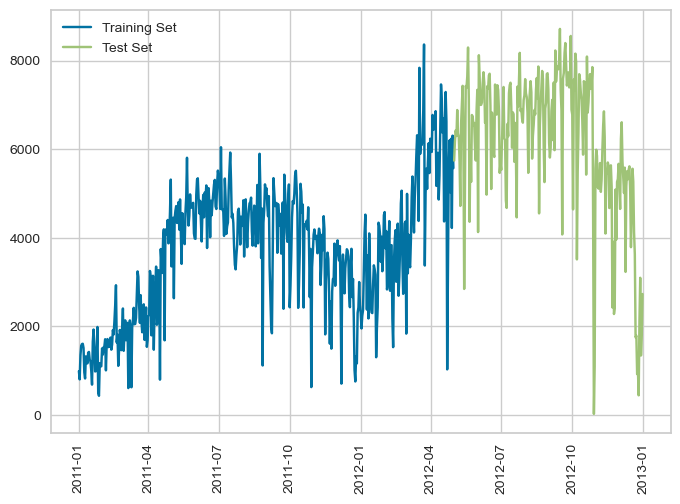

In [17]:
train=df1[df1.index < '05-01-2012']
test= df1[df1.index >= '05-01-2012']
plt.plot(train.index, train['cnt'])
plt.plot(test.index, test['cnt'])
plt.xticks(rotation=90)
plt.legend(['Training Set', 'Test Set'])

plt.show()

Plotting cross-validation 

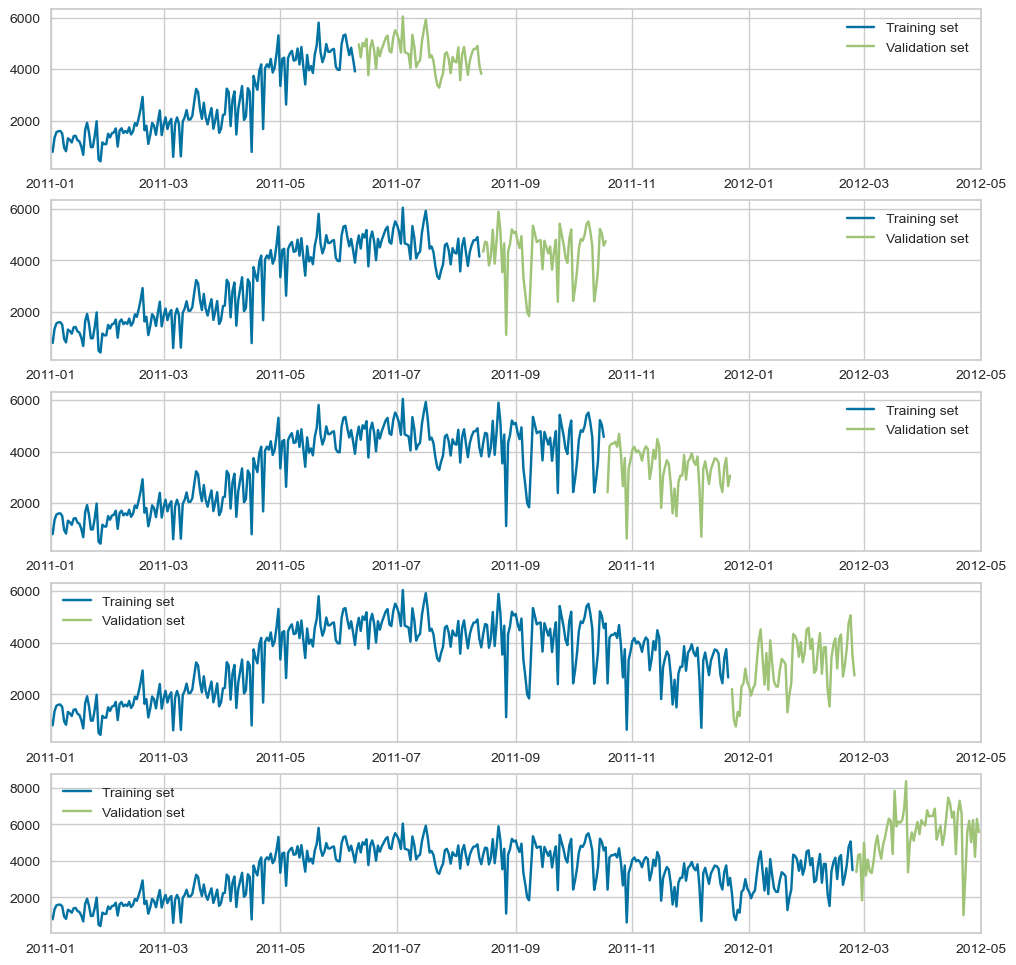

In [18]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()
fig=plt.figure(figsize=(12,12))

count=0
for train_in, val_in in cross_val.split(train):
    train_valid=df1.iloc[train_in]
    validation=df1.iloc[val_in]
    plt.subplot2grid((5,1),(count,0))
    plt.plot(train_valid.index, train_valid['cnt'])
    plt.plot(validation.index,validation['cnt'])
    plt.legend(['Training set','Validation set'])
    plt.xlim([dt.date(2011, 1, 1), dt.date(2012, 5, 1)])
    count+=1

plt.show()

Define x and y and fit the model 

In [19]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    x_val=validation['cnt']
    model = ARIMA(x_train, order=(0,1,0))
    model_fit = model.fit()

    print(model_fit.summary())
    print('##############################################################################')
    print('##################################   END   ###################################')
    print('##############################################################################')





                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  160
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1273.512
Date:                Sun, 05 Feb 2023   AIC                           2549.024
Time:                        16:51:34   BIC                           2552.093
Sample:                    01-01-2011   HQIC                          2550.270
                         - 06-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.269e+05   3.74e+04     14.079      0.000    4.54e+05       6e+05
Ljung-Box (L1) (Q):                  22.94   Jarque-Bera (JB):                58.27
Prob(Q):                              0.00   Pr

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWar

Plot residuals

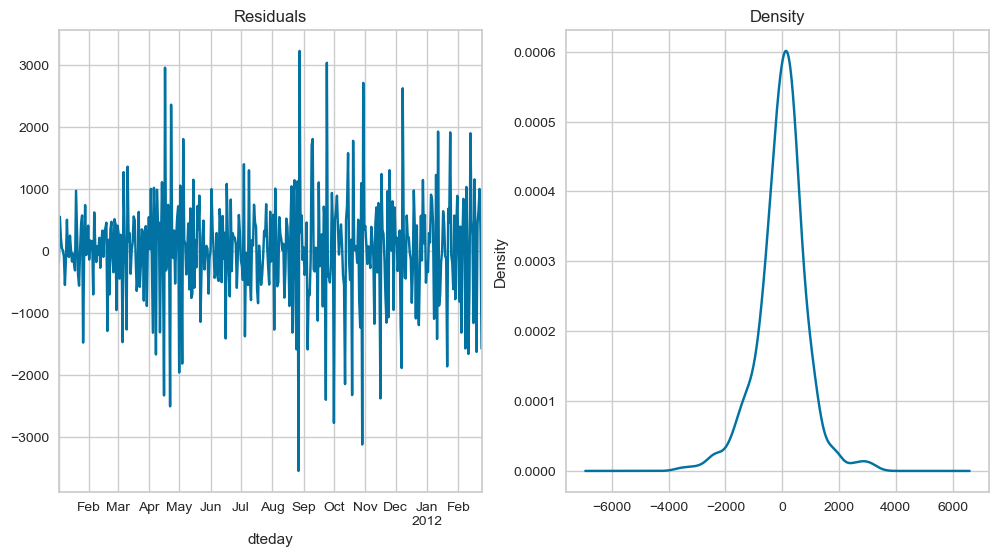

In [20]:
residuals = model_fit.resid[1:]
fig=plt.figure(figsize=(12,6))
plt.subplot2grid((1,2),(0,0))
residuals.plot(title='Residuals')
plt.subplot2grid((1,2),(0,1))

residuals.plot(title='Density', kind='kde')
plt.show()

Let's plot the ACF and PACF of residuals 

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


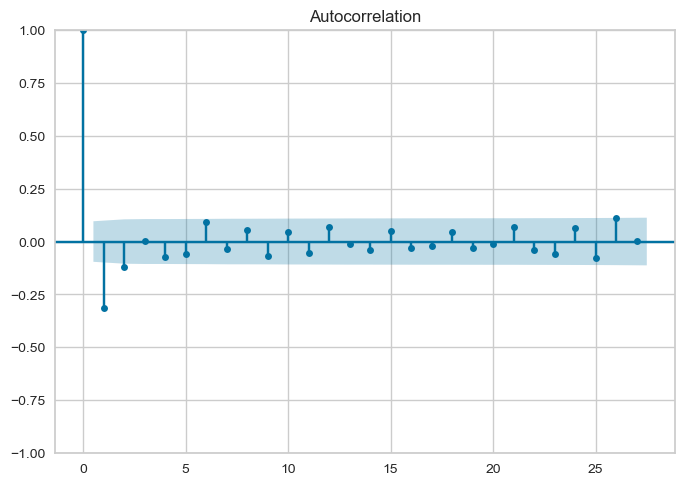

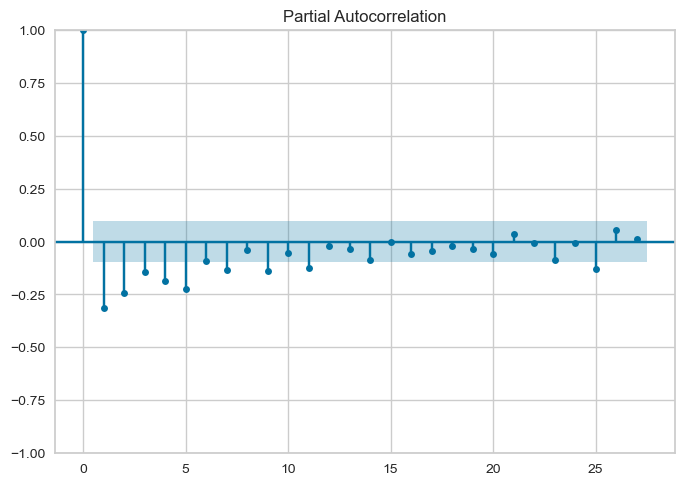

In [21]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

As it is obsious from above plots, there are some residuals which are beyond the significant interval, indicating that our model could not perform good (it is also clear from the magnitude of residuals). 

Let's use Auto-fit method 

In [22]:
auto_arima = pm.auto_arima(x_train, stepwise=False, seasonal=False)
auto_arima

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in recipr

ARIMA(order=(1, 1, 1), scoring_args={}, suppress_warnings=True)

Let's try with (1,1,1)

In [23]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    x_val=validation['cnt']
    model = ARIMA(x_train, order=(1,1,1))
    model_fit = model.fit()

    print(model_fit.summary())
    print('##############################################################################')
    print('##################################   END   ###################################')
    print('##############################################################################')


/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWar

                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  160
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1240.639
Date:                Sun, 05 Feb 2023   AIC                           2487.278
Time:                        16:51:40   BIC                           2496.484
Sample:                    01-01-2011   HQIC                          2491.016
                         - 06-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0698      0.086      0.813      0.416      -0.098       0.238
ma.L1         -0.7901      0.054    -14.611      0.000      -0.896      -0.684
sigma2      3.484e+05   3.64e+04      9.583      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  420
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3358.568
Date:                Sun, 05 Feb 2023   AIC                           6723.136
Time:                        16:51:41   BIC                           6735.250
Sample:                    01-01-2011   HQIC                          6727.924
                         - 02-24-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3272      0.050      6.511      0.000       0.229       0.426
ma.L1         -0.8956      0.027    -32.825      0.000      -0.949      -0.842
sigma2      5.355e+05    2.5e+04     21.412      0.0

Apply on the whole train dataset

In [24]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt','registered','atemp','hum'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt','registered','atemp','hum'], axis=1)

model = ARIMA(x_train_total, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())


/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  486
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3943.153
Date:                Sun, 05 Feb 2023   AIC                           7892.306
Time:                        16:51:41   BIC                           7904.858
Sample:                    01-01-2011   HQIC                          7897.238
                         - 04-30-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2661      0.050      5.341      0.000       0.168       0.364
ma.L1         -0.8744      0.023    -38.373      0.000      -0.919      -0.830
sigma2      6.737e+05   2.34e+04     28.790      0.0

Plot residuals

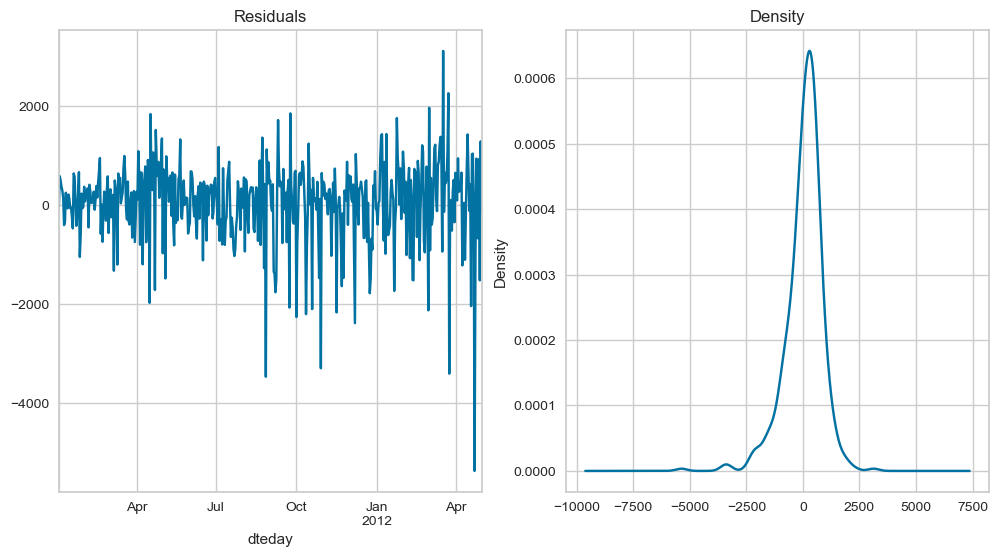

In [25]:
residuals = model_fit.resid[1:]
fig=plt.figure(figsize=(12,6))
plt.subplot2grid((1,2),(0,0))
residuals.plot(title='Residuals')
plt.subplot2grid((1,2),(0,1))

residuals.plot(title='Density', kind='kde')
plt.show()

Plot prediction and observation

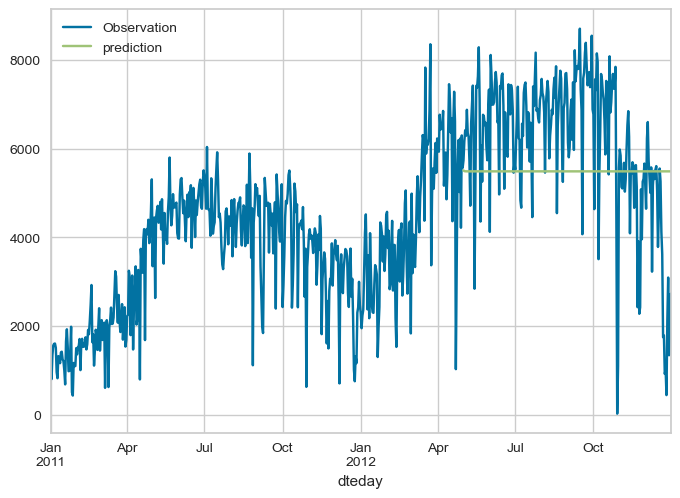

In [26]:
forecast_test = model_fit.forecast(len(x_test))
df1['forecast_manual'] = [None]*len(x_train_total) + list(forecast_test)
df1['cnt'].plot()
df1['forecast_manual'].plot()
plt.legend(['Observation','prediction'])


In [27]:
print('Mean absolute error is: ',mean_absolute_error(x_test, df1['forecast_manual'].dropna()))
print('Rsquare is: ',r2_score(x_test, df1['forecast_manual'].dropna()))

Mean absolute error is:  1431.2920617585798
Rsquare is:  -0.1751579787138715


Let's use ARIMAX

In [28]:
test.drop('yr', axis=1, inplace=True)
train.drop('yr', axis=1, inplace=True)

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_34605/1658429793.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('yr', axis=1, inplace=True)


In [29]:
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    y_train=train_valid.drop(['cnt','registered','atemp','hum'], axis=1)
    x_val=validation['cnt']
    model = ARIMA(x_train, order=(1,1,1),exog=y_train)
    model_fit = model.fit()

    print(model_fit.summary())
    print('##############################################################################')
    print('##################################   END   ###################################')
    print('##############################################################################')

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_mo

                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  160
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1203.180
Date:                Sun, 05 Feb 2023   AIC                           2428.359
Time:                        16:51:42   BIC                           2462.117
Sample:                    01-01-2011   HQIC                          2442.068
                         - 06-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season      -120.2854    986.802     -0.122      0.903   -2054.381    1813.810
mnth          84.2874    164.022      0.514      0.607    -237.189     405.764
holiday       33.3544    208.729      0.160      0.8

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1706.608
Date:                Sun, 05 Feb 2023   AIC                           3435.216
Time:                        16:51:42   BIC                           3472.744
Sample:                    01-01-2011   HQIC                          3450.364
                         - 08-13-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season       263.8175    311.282      0.848      0.397    -346.285     873.920
mnth          61.2365    148.656      0.412      0.680    -230.124     352.597
holiday      343.7344    140.819      2.441      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  290
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2248.174
Date:                Sun, 05 Feb 2023   AIC                           4518.349
Time:                        16:51:43   BIC                           4558.679
Sample:                    01-01-2011   HQIC                          4534.509
                         - 10-17-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season      -482.6960    151.911     -3.177      0.001    -780.437    -184.955
mnth         -86.3613    180.762     -0.478      0.633    -440.648     267.925
holiday      123.5374    186.632      0.662      0.5

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  355
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2750.665
Date:                Sun, 05 Feb 2023   AIC                           5523.329
Time:                        16:51:43   BIC                           5565.891
Sample:                    01-01-2011   HQIC                          5540.263
                         - 12-21-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
season       131.5992    135.376      0.972      0.331    -133.732     396.930
mnth          92.3856    123.494      0.748      0.454    -149.658     334.429
holiday      -57.0555    135.142     -0.422      0.6

p season in almost all cases is high so I remove it.

In [30]:
test.drop('season', axis=1, inplace=True)
train.drop('season', axis=1, inplace=True)
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    y_train=train_valid.drop(['cnt','registered','atemp','hum'], axis=1)
    x_val=validation['cnt']
    model = ARIMA(x_train, order=(1,1,1),exog=y_train)
    model_fit = model.fit()

    print(model_fit.summary())
    print('##############################################################################')
    print('##################################   END   ###################################')
    print('##############################################################################')

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_34605/918123882.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('season', axis=1, inplace=True)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self.

                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  160
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1203.451
Date:                Sun, 05 Feb 2023   AIC                           2426.903
Time:                        16:51:44   BIC                           2457.592
Sample:                    01-01-2011   HQIC                          2439.365
                         - 06-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mnth          60.3468    141.889      0.425      0.671    -217.750     338.444
holiday       42.7005    187.148      0.228      0.820    -324.103     409.504
weekday       39.9823     16.066      2.489      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1706.649
Date:                Sun, 05 Feb 2023   AIC                           3433.297
Time:                        16:51:44   BIC                           3467.414
Sample:                    01-01-2011   HQIC                          3447.068
                         - 08-13-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mnth          77.8651    160.556      0.485      0.628    -236.818     392.548
holiday      341.6112    143.676      2.378      0.017      60.011     623.211
weekday       31.2648     16.816      1.859      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  290
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2242.463
Date:                Sun, 05 Feb 2023   AIC                           4504.926
Time:                        16:51:45   BIC                           4541.590
Sample:                    01-01-2011   HQIC                          4519.617
                         - 10-17-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mnth         157.6240    128.117      1.230      0.219     -93.481     408.729
holiday      104.4680    176.257      0.593      0.553    -240.989     449.925
weekday       26.4662     19.216      1.377      0.1

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  355
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2751.080
Date:                Sun, 05 Feb 2023   AIC                           5522.161
Time:                        16:51:45   BIC                           5560.854
Sample:                    01-01-2011   HQIC                          5537.555
                         - 12-21-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
mnth          96.5276    124.432      0.776      0.438    -147.354     340.409
holiday      -56.9316    134.483     -0.423      0.672    -320.514     206.651
weekday       22.7101     17.773      1.278      0.2

I remove month and holiday

In [31]:
test.drop(['mnth','holiday'], axis=1, inplace=True)
train.drop(['mnth','holiday'], axis=1, inplace=True)
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    y_train=train_valid.drop(['cnt','registered','atemp','hum'], axis=1)
    x_val=validation['cnt']
    model = ARIMA(x_train, order=(1,1,1),exog=y_train)
    model_fit = model.fit()

    print(model_fit.summary())
    print('##############################################################################')
    print('##################################   END   ###################################')
    print('##############################################################################')

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_34605/3090534734.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['mnth','holiday'], axis=1, inplace=True)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be us

                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  160
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1203.102
Date:                Sun, 05 Feb 2023   AIC                           2422.204
Time:                        16:51:46   BIC                           2446.756
Sample:                    01-01-2011   HQIC                          2432.174
                         - 06-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       36.6392     17.671      2.073      0.038       2.005      71.273
workingday    25.9802     75.246      0.345      0.730    -121.499     173.459
weathersit  -534.2774     59.590     -8.966      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1707.540
Date:                Sun, 05 Feb 2023   AIC                           3431.080
Time:                        16:51:46   BIC                           3458.373
Sample:                    01-01-2011   HQIC                          3442.097
                         - 08-13-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       30.1702     16.758      1.800      0.072      -2.676      63.016
workingday   -42.9987     71.704     -0.600      0.549    -183.537      97.540
weathersit  -478.6970     56.425     -8.484      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  290
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2242.991
Date:                Sun, 05 Feb 2023   AIC                           4501.982
Time:                        16:51:46   BIC                           4531.314
Sample:                    01-01-2011   HQIC                          4513.735
                         - 10-17-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       21.7756     18.661      1.167      0.243     -14.800      58.351
workingday   -46.6380     71.884     -0.649      0.516    -187.528      94.252
weathersit  -624.4053     62.571     -9.979      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  355
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2751.935
Date:                Sun, 05 Feb 2023   AIC                           5519.869
Time:                        16:51:46   BIC                           5550.824
Sample:                    01-01-2011   HQIC                          5532.185
                         - 12-21-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       23.5167     17.819      1.320      0.187     -11.407      58.440
workingday    38.5270     64.337      0.599      0.549     -87.570     164.624
weathersit  -653.4751     50.263    -13.001      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  420
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3262.034
Date:                Sun, 05 Feb 2023   AIC                           6540.067
Time:                        16:51:47   BIC                           6572.370
Sample:                    01-01-2011   HQIC                          6552.836
                         - 02-24-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       32.5233     15.618      2.082      0.037       1.912      63.135
workingday    99.2333     60.464      1.641      0.101     -19.275     217.741
weathersit  -643.1874     46.154    -13.936      0.0

Remove working day as well

In [32]:
test.drop('workingday', axis=1, inplace=True)
train.drop('workingday', axis=1, inplace=True)
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    y_train=train_valid.drop(['cnt','registered','atemp','hum'], axis=1)
    x_val=validation['cnt']
    model = ARIMA(x_train, order=(1,1,1),exog=y_train)
    model_fit = model.fit()

    print(model_fit.summary())
    print('##############################################################################')
    print('##################################   END   ###################################')
    print('##############################################################################')

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_34605/798958532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('workingday', axis=1, inplace=True)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  s

                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  160
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1203.015
Date:                Sun, 05 Feb 2023   AIC                           2420.029
Time:                        16:51:47   BIC                           2441.512
Sample:                    01-01-2011   HQIC                          2428.753
                         - 06-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       32.4820     17.334      1.874      0.061      -1.493      66.457
weathersit  -542.8719     58.570     -9.269      0.000    -657.668    -428.076
temp        3621.8642    580.983      6.234      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  355
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2752.183
Date:                Sun, 05 Feb 2023   AIC                           5518.366
Time:                        16:51:48   BIC                           5545.451
Sample:                    01-01-2011   HQIC                          5529.142
                         - 12-21-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       23.7300     17.709      1.340      0.180     -10.979      58.439
weathersit  -651.5348     49.829    -13.075      0.000    -749.198    -553.872
temp        3282.7496    515.911      6.363      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  420
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3263.954
Date:                Sun, 05 Feb 2023   AIC                           6541.908
Time:                        16:51:48   BIC                           6570.173
Sample:                    01-01-2011   HQIC                          6553.080
                         - 02-24-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weekday       33.5800     15.671      2.143      0.032       2.865      64.295
weathersit  -639.0614     46.389    -13.776      0.000    -729.981    -548.142
temp        4254.6620    447.855      9.500      0.0

In [33]:
test.drop('weekday', axis=1, inplace=True)
train.drop('weekday', axis=1, inplace=True)
cross_val=TimeSeriesSplit(n_splits=5, test_size=65, gap=1)
train=train.sort_index()

for train_in, val_in in cross_val.split(train):
    train_valid=train.iloc[train_in]
    validation=train.iloc[val_in]
    x_train=train_valid['cnt']
    y_train=train_valid.drop(['cnt','registered','atemp','hum'], axis=1)
    x_val=validation['cnt']
    model = ARIMA(x_train, order=(1,1,1),exog=y_train)
    model_fit = model.fit()

    print(model_fit.summary())
    print('##############################################################################')
    print('##################################   END   ###################################')
    print('##############################################################################')

/var/folders/nm/btrww2_94pncl34mb0yt49j80000gn/T/ipykernel_34605/2197150074.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop('weekday', axis=1, inplace=True)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  sel

                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  160
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1203.948
Date:                Sun, 05 Feb 2023   AIC                           2419.895
Time:                        16:51:48   BIC                           2438.309
Sample:                    01-01-2011   HQIC                          2427.373
                         - 06-09-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weathersit  -519.2191     60.926     -8.522      0.000    -638.632    -399.806
temp        2874.7840    531.654      5.407      0.000    1832.760    3916.808
windspeed  -1135.6736    532.693     -2.132      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  225
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1707.813
Date:                Sun, 05 Feb 2023   AIC                           3427.627
Time:                        16:51:48   BIC                           3448.097
Sample:                    01-01-2011   HQIC                          3435.889
                         - 08-13-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weathersit  -475.5184     57.653     -8.248      0.000    -588.516    -362.520
temp        1965.5995    526.144      3.736      0.000     934.375    2996.824
windspeed   -735.1116    502.357     -1.463      0.1

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  290
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2243.779
Date:                Sun, 05 Feb 2023   AIC                           4499.557
Time:                        16:51:49   BIC                           4521.556
Sample:                    01-01-2011   HQIC                          4508.372
                         - 10-17-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weathersit  -621.4555     62.857     -9.887      0.000    -744.652    -498.259
temp        3041.6776    613.903      4.955      0.000    1838.450    4244.905
windspeed  -1370.5276    429.260     -3.193      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  355
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2752.892
Date:                Sun, 05 Feb 2023   AIC                           5517.783
Time:                        16:51:49   BIC                           5540.999
Sample:                    01-01-2011   HQIC                          5527.020
                         - 12-21-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weathersit  -674.4812     49.971    -13.497      0.000    -772.423    -576.540
temp        3147.8406    496.779      6.337      0.000    2174.172    4121.509
windspeed  -1328.3977    396.847     -3.347      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Apply on the whole train dataset

In [34]:
x_train_total=train['cnt']
y_train_total=train.drop(['cnt','registered','atemp','hum'], axis=1)
x_test=test['cnt']
y_test=test.drop(['cnt','registered','atemp','hum'], axis=1)

model = ARIMA(x_train_total, order=(1,1,1),exog=y_train_total)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    cnt   No. Observations:                  486
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3827.058
Date:                Sun, 05 Feb 2023   AIC                           7666.116
Time:                        16:51:49   BIC                           7691.221
Sample:                    01-01-2011   HQIC                          7675.980
                         - 04-30-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
weathersit  -697.7409     43.901    -15.894      0.000    -783.784    -611.697
temp        5411.3385    455.280     11.886      0.000    4519.005    6303.671
windspeed  -1745.6683    391.518     -4.459      0.0

/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/marziehbaes/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


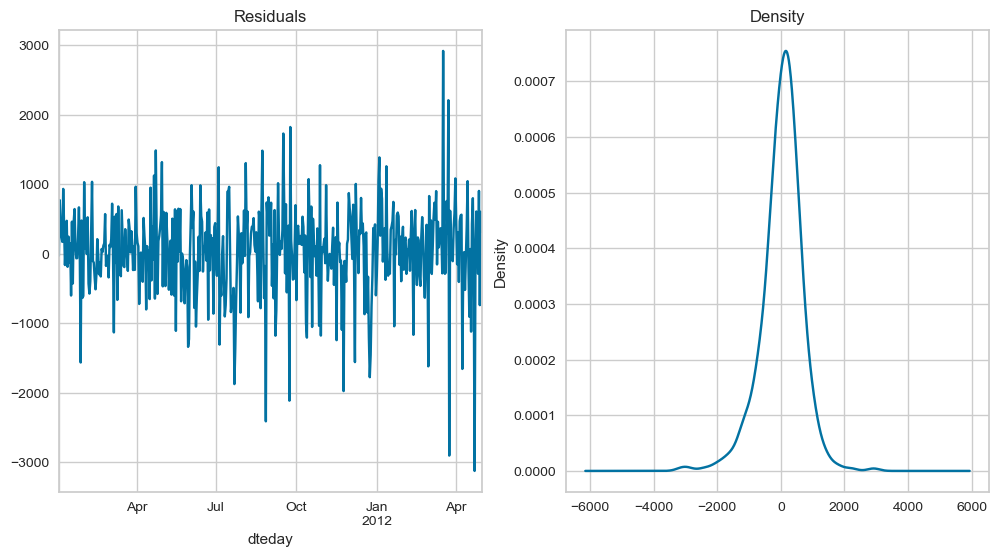

In [35]:
residuals = model_fit.resid[1:]
fig=plt.figure(figsize=(12,6))
plt.subplot2grid((1,2),(0,0))
residuals.plot(title='Residuals')
plt.subplot2grid((1,2),(0,1))

residuals.plot(title='Density', kind='kde')
plt.show()

In [36]:
forecast_test

2012-05-01    5513.869365
2012-05-02    5498.402914
2012-05-03    5494.287853
2012-05-04    5493.192985
2012-05-05    5492.901680
                 ...     
2012-12-27    5492.796078
2012-12-28    5492.796078
2012-12-29    5492.796078
2012-12-30    5492.796078
2012-12-31    5492.796078
Freq: D, Name: predicted_mean, Length: 245, dtype: float64

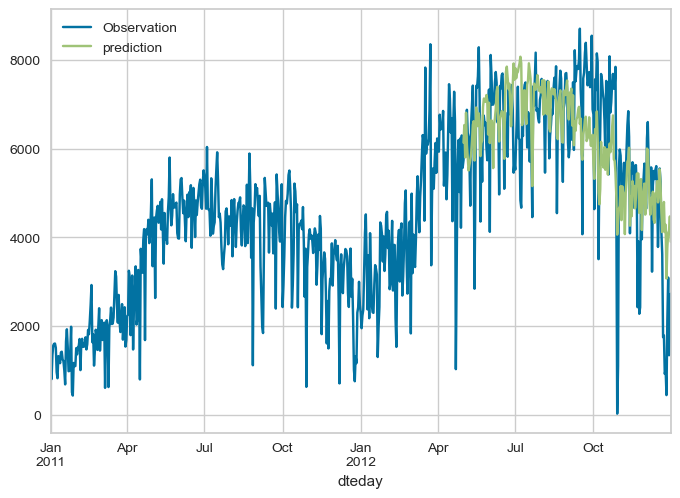

In [37]:
forecast_test = model_fit.forecast(len(x_test),exog=y_test)
df1['forecast_manual'] = [None]*len(x_train_total) + list(forecast_test)
df1['cnt'].plot()
df1['forecast_manual'].plot()
plt.legend(['Observation','prediction'])


In [38]:
print('Mean absolute error is: ',mean_absolute_error(x_test, df1['forecast_manual'].dropna()))
print('Rsquare is: ',r2_score(x_test, df1['forecast_manual'].dropna()))


Mean absolute error is:  945.3582202372436
Rsquare is:  0.4353781197911719
